In [1]:
import numpy as np 
import pandas as pd
import datetime
import math

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FixedLocator, FixedFormatter, FuncFormatter
import matplotlib.ticker as mtick
from matplotlib import lines, patches
import seaborn as sns

import os, sys, pathlib
from IPython.display import Markdown, display

from ast import literal_eval

pd.options.mode.use_inf_as_na = True

**products**: inventory_item_id maps to id in inventory

**inventory**: all inventory

**orders**:  all orders

**orders_line_items**: all line-items

**inbound_shipments**: all Inbound Shipments

**suppliers**: all inbound shipment suppliers

**shipping_methods**: all shipping methods

## Data ingestion

In [2]:
# get list of files
files = os.listdir()
files = [f for f in files if f[-4:] == '.csv']
files.sort()

# load them
archive = {x: [] for x in list(set([f[:-4] for f in files]))}
for f in files:
    archive[f[:-4]] = pd.read_csv(f, on_bad_lines='skip')
print('Downloads done.')

# fix dates
for file, df in archive.items():
    for col in df.columns:
        if '_date' in col:
            df[col] = pd.to_datetime(df[col]).dt.date

Downloads done.


In [3]:
for file, df in archive.items():
    print(f'{file}: {len(df)} rows')
    for col in df.columns:
        if 'date' in col:
            if (~df[col].isnull()).sum() > 0:
                print(f'{col}: {df[~df[col].isnull()][col].min()} to {df[~df[col].isnull()][col].max()}')
    #display(df.head(3))
    print('')

temp_velocity: 1210 rows

products: 1267 rows
created_date: 2023-10-09 to 2024-07-18
updated_date: 2024-01-10 to 2024-07-28

temp_b2b_velocity: 251 rows

orders_line_items: 192616 rows

temp: 1265 rows

inbound_shipments: 31 rows
created_date: 2024-06-07 to 2024-07-22
updated_date: 2024-06-12 to 2024-07-26
expected_arrival_date: 2024-06-06 to 2024-07-22

inventory: 1267 rows
created_date: 2023-10-09 to 2024-07-18
updated_date: 2024-01-10 to 2024-07-28

orders: 135011 rows
created_date: 2023-10-12 to 2024-07-28
updated_date: 2023-10-13 to 2024-07-28
required_ship_date: 2023-10-12 to 2024-07-28

temp_b2b_avg: 251 rows

shipping_methods: 297 rows
created_date: 2024-07-11 to 2024-07-11
updated_date: 2024-07-11 to 2024-07-11

suppliers: 4 rows
created_date: 2024-07-11 to 2024-07-16
updated_date: 2024-07-11 to 2024-07-16

temp_avg: 1210 rows

temp_clean: 1013 rows



In [4]:
for file, df in archive.items():
    print(f'{file}')
    display(df.head(2))
    print('')

temp_velocity


,sku,w1,w3,w6
0,AB10BBLK00,2.0,1.333333,5.5
1,AB10BBLK10,3.0,1.666667,1.0



products


,id,warehouse_customer_id,created_date,updated_date,name,sku,gtin,inventory_items,is_kit,active,supplier,country_of_origin,harmonized_code,supplier_products,external_system_url
0,AB10BBLK00_20494,20494,2024-03-06,2024-07-19,Abbey Blue-light Black 0,AB10BBLK00,8.520550e+11,"[{'inventory_item_id': 'AB10BBLK00_20494', 'sk...",False,True,NaN,NaN,NaN,[],https://shipcalm.infopluswms.com/infoplus-wms/...
1,AB10BBLK10_20494,20494,2024-04-09,2024-07-17,Abbey Blue-light Black 1,AB10BBLK10,8.520550e+11,"[{'inventory_item_id': 'AB10BBLK10_20494', 'sk...",False,True,NaN,NaN,NaN,[],https://shipcalm.infopluswms.com/infoplus-wms/...



temp_b2b_velocity


,sku,w1,w3,w6
0,AB10BLK15,0.0,0.0,4.0
1,AB10BLK20,0.0,0.0,2.0



orders_line_items


,product_id,sku,quantity,unit_price,is_picked,discount_amount,id
0,CO70BLK10_20494,CO70BLK10,1,44.2,True,NaN,1000033.0
1,CO70CRN10_20494,CO70CRN10,1,68.0,True,NaN,1000033.0



temp


,sku,available,6,min,value
0,AB10BBLK00,129.0,198.0,129.0,6825.272727
1,AB10BBLK15,6.0,120.0,6.0,316.800000



inbound_shipments


,id,warehouse_customer_id,created_date,updated_date,purchase_order_number,status,raw_status,supplier,expected_arrival_date,warehouse_id,line_items,receipts,ship_from_address,tracking_numbers,notes,external_system_url
0,151830,20494,2024-06-07,2024-06-13,ASN-060624,open,Partially Received,1296.0,2024-06-06,2135,"[{'inventory_item_id': 'AB10NAV10_20494', 'sku...","[{'id': '232170', 'arrived_date': '2024-06-13T...","{'address1': None, 'address2': None, 'address3...",[],[],https://shipcalm.infopluswms.com/infoplus-wms/...
1,152888,20494,2024-06-12,2024-06-12,TRN-EDB7DA4-B70A-468D-A7C7-DFFD26,received,Received,NaN,2024-06-12,2135,"[{'inventory_item_id': 'MI15CHE30-R_20494', 's...","[{'id': '233902', 'arrived_date': '2024-06-12T...","{'address1': None, 'address2': None, 'address3...",[],[],https://shipcalm.infopluswms.com/infoplus-wms/...



inventory


,id,warehouse_customer_id,created_date,updated_date,name,sku,active,awaiting,onhand,committed,unfulfillable,fulfillable,unsellable,sellable,substitute_skus,inventory_by_warehouse_id,lots,measurements,locations,external_system_url
0,AB10BBLK00_20494,20494,2024-03-06,2024-07-19,Abbey Blue-light Black 0,AB10BBLK00,True,0,129,0,0,129,0,129,[],"{'2121': {'awaiting': 0, 'onhand': 0, 'committ...",[],"{'length': 6.9, 'width': 3.2, 'height': 1.8, '...",[],https://shipcalm.infopluswms.com/infoplus-wms/...
1,AB10BBLK10_20494,20494,2024-04-09,2024-07-18,Abbey Blue-light Black 1,AB10BBLK10,True,0,0,0,0,0,0,0,[],"{'2121': {'awaiting': 0, 'onhand': 0, 'committ...",[],"{'length': 6.9, 'width': 3.2, 'height': 1.8, '...",[],https://shipcalm.infopluswms.com/infoplus-wms/...



orders


,id,warehouse_customer_id,created_date,updated_date,reference_id,order_number,status,raw_status,channel,type,...,total_price,total_tax,total_discount,total_shipping,ship_to_address,line_items,tags,required_ship_date,shipments,external_system_url
0,1000033.0,20494,2023-11-25,2023-11-25,1000033.0,1000033.0,fulfilled,Shipped,NaN,NaN,...,194.15,13.95,NaN,0.0,"{'full_name': None, 'company': 'SVITLANA NATA...","[{'product_id': 'CO70BLK10_20494', 'sku': 'CO7...",[],2023-11-25,"[{'shipment_id': '920940', 'warehouse_id': '21...",https://shipcalm.infopluswms.com/infoplus-wms/...
1,1000063.0,20494,2023-11-25,2023-11-25,1000063.0,1000063.0,fulfilled,Shipped,NaN,NaN,...,166.00,0.00,NaN,0.0,"{'full_name': None, 'company': 'KELLY FOEHNER'...","[{'product_id': 'BO20SGB15_20494', 'sku': 'BO2...",[],2023-11-25,"[{'shipment_id': '920964', 'warehouse_id': '21...",https://shipcalm.infopluswms.com/infoplus-wms/...



temp_b2b_avg


,sku,1,3,6
0,AB10BLK15,NaN,NaN,66.012727
1,AB10BLK20,NaN,NaN,72.392857



shipping_methods


,id,created_date,updated_date,name,carrier
0,0,2024-07-11,2024-07-11,UPS GROUND (UPS 0),NaN
1,1,2024-07-11,2024-07-11,UPS-1 DAY (UPS 1),NaN



suppliers


,id,created_date,updated_date
0,1295,2024-07-11,2024-07-11
1,1296,2024-07-11,2024-07-11



temp_avg


,sku,1,3,6
0,AB10BBLK00,38.000000,63.0,52.909091
1,AB10BBLK10,54.666667,68.0,71.333333



temp_clean


,sku,available,inbound,total
0,AB10BBLK00,129,0,129
1,AB10BBLK15,6,0,6


### Preprocess sales data

In [5]:
orders = archive['orders'].copy()
lineitems = archive['orders_line_items'].copy()
products = archive['products'].copy()

order_dates = orders.set_index('id')['created_date'].to_dict()
product_names = products.set_index('sku')['name'].to_dict()

lineitems['date'] = lineitems.id.apply(lambda x: order_dates[x])
lineitems['month'] = lineitems['date'].apply(lambda x: datetime.date(x.year, x.month, 1))
lineitems['price'] = lineitems.quantity * lineitems.unit_price

### Are item prices Gross or Net?

In [6]:
temp = pd.concat([lineitems.groupby('sku')['month'].nunique(), \
                  lineitems.groupby('sku')['quantity'].sum()], axis=1)
temp['per_month'] = temp.quantity / temp.month
temp['name'] = temp.index.map(lambda x: product_names[x])
top_skus = list(temp.sort_values(by=['month', 'per_month'], ascending=False).index.values[:5])

In [7]:
lineitems[(lineitems.sku.isin(top_skus)) & (lineitems.quantity > 4)].head()

,product_id,sku,quantity,unit_price,is_picked,discount_amount,id,date,month,price
139230,CO70PTOR15_20494,CO70PTOR15,72,0.0,True,NaN,1523505.0,2024-06-10,2024-06-01,0.0
139235,CO70PTPE15_20494,CO70PTPE15,60,0.0,True,NaN,1523505.0,2024-06-10,2024-06-01,0.0
139236,CO70PTPE20_20494,CO70PTPE20,48,0.0,True,NaN,1523505.0,2024-06-10,2024-06-01,0.0
139248,LA40PTOR15_20494,LA40PTOR15,72,0.0,True,NaN,1523505.0,2024-06-10,2024-06-01,0.0
168576,CO70PTPE15_20494,CO70PTPE15,24,0.0,True,NaN,1618300.0,2024-07-15,2024-07-01,0.0


**Bulk transfers can show up as unit_price = 0**

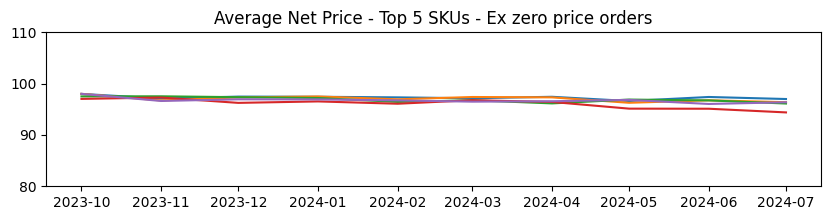

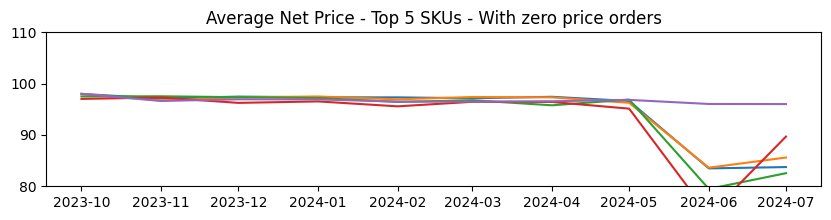

In [8]:
def top_sku_prices(top_skus, lineitems, non_zero_price=True):
    prices = []
    for sku in top_skus:
        if non_zero_price:
            mask = (lineitems.sku == sku) & (lineitems.unit_price > 0)
        else:
            mask = (lineitems.sku == sku)
        temp = pd.concat([lineitems[mask].groupby('month')['price'].sum(), \
                          lineitems[mask].groupby('month')['quantity'].sum(), \
                          lineitems[mask].groupby('month')['unit_price'].max()], axis=1)
        temp['avg_price'] = temp['price'] / temp['quantity']
        prices.append(temp['avg_price'])
    return pd.concat(prices, axis=1, keys=[product_names[sku] for sku in top_skus])

top_sku_prices(top_skus, lineitems, True).plot(figsize=(10,2), title='Average Net Price - Top 5 SKUs - Ex zero price orders', \
                                               ylim=(80,110), xlabel='', legend=None);
top_sku_prices(top_skus, lineitems, False).plot(figsize=(10,2), title='Average Net Price - Top 5 SKUs - With zero price orders', \
                                               ylim=(80,110), xlabel='', legend=None);

### Establish sales velocities

In [9]:
windows = [1,3,6]

In [10]:
# average price - trailing 1 / 3 / 6 month average
p = pd.pivot_table(lineitems[lineitems.unit_price > 0], index='sku', columns='month', values='price', aggfunc='sum')
q = pd.pivot_table(lineitems[lineitems.unit_price > 0], index='sku', columns='month', values='quantity', aggfunc='sum')

avg = {}
for w in windows:
    avg[w] = p.fillna(0).rolling(axis=1, window=w).sum() / q.fillna(0).rolling(axis=1, window=w).sum()

In [11]:
b2b_q = pd.pivot_table(lineitems[lineitems.unit_price == 0], index='sku', columns='month', values='quantity', aggfunc='sum')
b2b_skus = set(b2b_q.index.values)

b2b_p, b2b_avg = {}, {}
for w in windows:
    b2b_p[w] = b2b_q * avg[w][avg[w].index.isin(b2b_skus)].bfill(axis=1)
    b2b_avg[w] = b2b_p[w].fillna(0).rolling(axis=1, window=w).sum() / b2b_q.fillna(0).rolling(axis=1, window=w).sum()

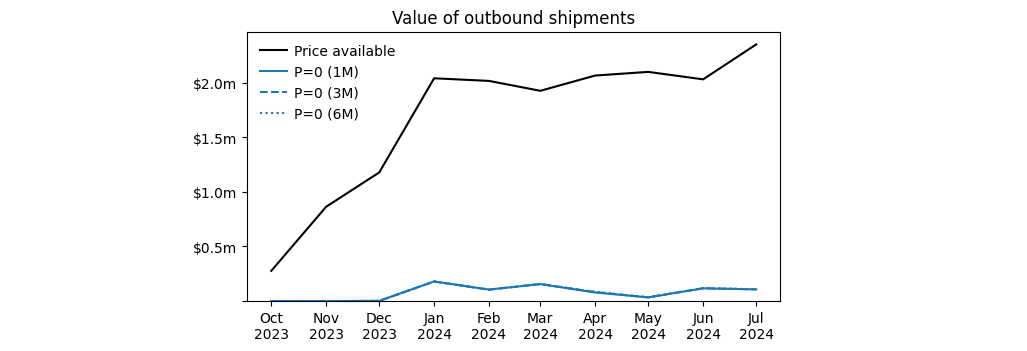

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(13,3.5), gridspec_kw={'width_ratios': [1, 3, 1]})
ax[0].axis('off')
ax[2].axis('off')
x = ax[1]
x.set_title('Value of outbound shipments')

p.sum(axis=0).plot(ax=x, c='black', label='Price available')
for i, w in enumerate(windows):
    b2b_p[w].sum(axis=0).plot(ax=x, c='tab:blue', ls=['-', '--', ':'][i], label=f'P=0 ({w}M)')

x.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
x.set_xlabel(None)
x.set_ylim(bottom=0)
x.yaxis.set_major_formatter(FuncFormatter(lambda x, p: '$'+format(x/1000000, ',.1f')+'m' if x!=0 else ''))
x.legend(title='', frameon=False, columnspacing=1, handletextpad=0.5, handlelength=2)

plt.show()
#plt.subplots(figsize= b2b_p[1].sum(axis=0)

### Inbound shipments / restocks

In [15]:
shipments = archive['inbound_shipments'].copy()

shipment_lineitems = []
for x in shipments.index.values:
    df = shipments[shipments.index == x].copy()
    temp = pd.DataFrame.from_dict(literal_eval(df.line_items.values[0]))
    for col in ['id', 'created_date', 'updated_date', 'expected_arrival_date', \
                'warehouse_customer_id', 'purchase_order_number', 'supplier', 'warehouse_id']:
        temp[col] = df[col].values[0]
    shipment_lineitems.append(temp)
shipment_lineitems = pd.concat(shipment_lineitems, axis=0, ignore_index=True)

shipment_lineitems['pending_quantity'] = shipment_lineitems.expected_quantity - shipment_lineitems.received_quantity
inbound_skus = shipment_lineitems[shipment_lineitems.pending_quantity != 0].groupby('sku')['pending_quantity'].sum().to_dict()

In [16]:
# orders with no available inventory and no inbound restock
inventory = archive['inventory'].copy()
inventory_by_sku = inventory.groupby('sku')[['active', 'awaiting', 'onhand', 'committed', \
                                             'unfulfillable', 'fulfillable', 'unsellable', 'sellable']].sum()
inventory_by_sku['inbound'] = inventory_by_sku.index.map(lambda x: inbound_skus[x] if x in inbound_skus else 0)

print('Committed, shipment pending restock')
display(inventory_by_sku[(inventory_by_sku.inbound >= -inventory_by_sku.sellable) & (inventory_by_sku.sellable < 0)])
print('')
print('Committed, reorder needed to fulfill')
display(inventory_by_sku[(inventory_by_sku.inbound < -inventory_by_sku.sellable) & (inventory_by_sku.sellable < 0)])

Committed, shipment pending restock


,active,awaiting,onhand,committed,unfulfillable,fulfillable,unsellable,sellable,inbound
sku,,,,,,,,,
AB10CHE10,1,0,0,2,0,-2,0,-2,12
AB10PCHE25,1,36,2,2,2,-2,0,-2,36
CO70BTPE10,1,0,0,2,0,-2,0,-2,12
CO70BTPE25,1,0,0,2,0,-2,0,-2,12
LGBOX,1,1000,0,2,0,-2,0,-2,1000
LI50TOR20,1,12,4,6,0,-2,0,-2,12



Committed, reorder needed to fulfill


,active,awaiting,onhand,committed,unfulfillable,fulfillable,unsellable,sellable,inbound
sku,,,,,,,,,
AB10BLK20,1,0,0,2,0,-2,0,-2,0
AB10BTPE00,1,0,0,2,0,-2,0,-2,0
AB10BTPE20,1,0,0,2,0,-2,0,-2,0
AB10CLR25,1,0,0,2,0,-2,0,-2,0
AB10TPE20,1,0,0,2,0,-2,0,-2,0
CA60CHE15,1,0,1,2,0,-1,0,-1,0
CA60CHE20,1,0,1,2,0,-1,0,-1,0
CA60CHE25,1,0,1,2,0,-1,0,-1,0
CA60TOR20,1,0,1,2,0,-1,0,-1,0


**What does it mean when awaiting != inbound?**

In [17]:
# This SKU has 12 units inbound but 'awaiting' in API is shown as zero
shipment_lineitems[shipment_lineitems.sku == 'AB10CHE10'].T

,994
inventory_item_id,AB10CHE10_20494
sku,AB10CHE10
expected_quantity,12
received_quantity,0
unit_cost,None
external_id,None
id,159842
created_date,2024-07-18
updated_date,2024-07-26
expected_arrival_date,2024-07-22


### Inventory overview

In [18]:
inventory_by_sku['available'] = inventory_by_sku.fulfillable.apply(lambda x: x if x>=0 else 0)
clean_inventory = inventory_by_sku[(inventory_by_sku.available > 0) | \
                                   (inventory_by_sku.inbound > 0)][['available', 'inbound']].copy()
clean_inventory['total'] = clean_inventory.sum(axis=1)

clean_inventory.sum(axis=0)

available    191775
inbound       30507
total        222282
dtype: int64

In [19]:
velocity = pd.concat([q.fillna(0).rolling(axis=1, window=w).sum().iloc[:,-1]/w for w in windows], axis=1, keys=windows)
b2b_velocity = pd.concat([b2b_q.fillna(0).rolling(axis=1, window=w).sum().iloc[:,-1]/w for w in windows], axis=1, keys=windows)
total_velocity = velocity.add(b2b_velocity, fill_value=0)

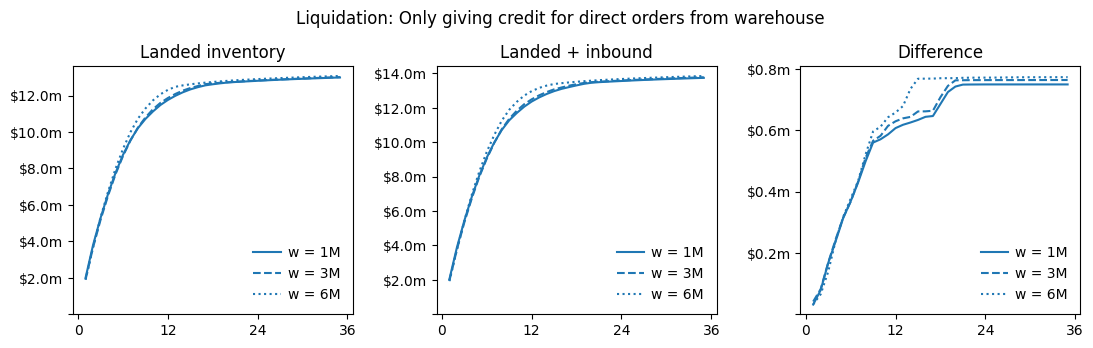

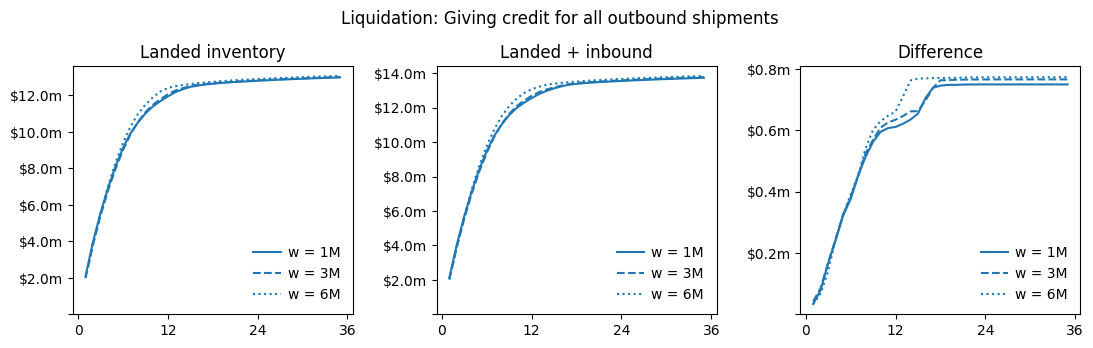

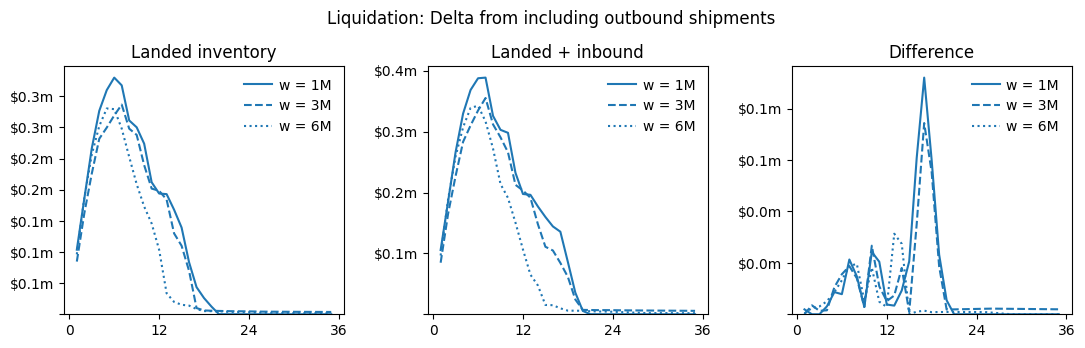

In [20]:
months = list(np.arange(1,36))

landed_liq = pd.concat([pd.concat([pd.concat([clean_inventory['available'], \
                                              velocity[w]*m], axis=1).fillna(0).min(axis=1) * avg[w].iloc[:,-1] \
                                   for m in months], axis=1, keys=months).sum(axis=0) \
                        for w in windows], axis=1, keys=windows)

all_liq = pd.concat([pd.concat([pd.concat([clean_inventory['total'], \
                                           velocity[w]*m], axis=1).fillna(0).min(axis=1) * avg[w].iloc[:,-1] \
                                 for m in months], axis=1, keys=months).sum(axis=0) \
                     for w in windows], axis=1, keys=windows)

landed_liq_full = pd.concat([pd.concat([pd.concat([clean_inventory['available'], \
                                                   total_velocity[w]*m], axis=1).fillna(0).min(axis=1) * avg[w].iloc[:,-1] \
                                        for m in months], axis=1, keys=months).sum(axis=0) \
                             for w in windows], axis=1, keys=windows)

all_liq_full = pd.concat([pd.concat([pd.concat([clean_inventory['total'], \
                                                total_velocity[w]*m], axis=1).fillna(0).min(axis=1) * avg[w].iloc[:,-1] \
                                     for m in months], axis=1, keys=months).sum(axis=0) \
                          for w in windows], axis=1, keys=windows)

linestyles = ['-', '--', ':']

fig, ax = plt.subplots(ncols=3, figsize=(13,3.5))
fig.suptitle('Liquidation: Only giving credit for direct orders from warehouse')
x = ax[0]
x.set_title('Landed inventory')
for i, w in enumerate(windows):
    landed_liq[w].plot(ax=x, c='tab:blue', ls=linestyles[i], label=f'w = {w}M')

x = ax[1]
x.set_title('Landed + inbound')
for i, w in enumerate(windows):
    all_liq[w].plot(ax=x, c='tab:blue', ls=linestyles[i], label=f'w = {w}M')

x = ax[2]
x.set_title('Difference')
for i, w in enumerate(windows):
    (all_liq[w] - landed_liq[w]).plot(ax=x, c='tab:blue', ls=linestyles[i], label=f'w = {w}M')

for x in ax:
    x.set_xlabel(None)
    x.xaxis.set_major_locator(mtick.MultipleLocator(base=12)) 
    x.set_ylim(bottom=0)
    x.yaxis.set_major_formatter(FuncFormatter(lambda x, p: '$'+format(x/1000000, ',.1f')+'m' if x!=0 else ''))
    x.legend(title='', frameon=False, columnspacing=1, handletextpad=0.5, handlelength=2)
plt.subplots_adjust(top=0.82, wspace=0.30)
plt.show()

fig, ax = plt.subplots(ncols=3, figsize=(13,3.5))
fig.suptitle('Liquidation: Giving credit for all outbound shipments')
x = ax[0]
x.set_title('Landed inventory')
for i, w in enumerate(windows):
    landed_liq_full[w].plot(ax=x, c='tab:blue', ls=linestyles[i], label=f'w = {w}M')

x = ax[1]
x.set_title('Landed + inbound')
for i, w in enumerate(windows):
    all_liq_full[w].plot(ax=x, c='tab:blue', ls=linestyles[i], label=f'w = {w}M')

x = ax[2]
x.set_title('Difference')
for i, w in enumerate(windows):
    (all_liq_full[w] - landed_liq_full[w]).plot(ax=x, c='tab:blue', ls=linestyles[i], label=f'w = {w}M')

for x in ax:
    x.set_xlabel(None)
    x.xaxis.set_major_locator(mtick.MultipleLocator(base=12)) 
    x.set_ylim(bottom=0)
    x.yaxis.set_major_formatter(FuncFormatter(lambda x, p: '$'+format(x/1000000, ',.1f')+'m' if x!=0 else ''))
    x.legend(title='', frameon=False, columnspacing=1, handletextpad=0.5, handlelength=2)
plt.subplots_adjust(top=0.82, wspace=0.30)
plt.show()

fig, ax = plt.subplots(ncols=3, figsize=(13,3.5))
fig.suptitle('Liquidation: Delta from including outbound shipments')
x = ax[0]
x.set_title('Landed inventory')
for i, w in enumerate(windows):
    (landed_liq_full[w]-landed_liq[w]).plot(ax=x, c='tab:blue', ls=linestyles[i], label=f'w = {w}M')

x = ax[1]
x.set_title('Landed + inbound')
for i, w in enumerate(windows):
    (all_liq_full[w]-all_liq[w]).plot(ax=x, c='tab:blue', ls=linestyles[i], label=f'w = {w}M')

x = ax[2]
x.set_title('Difference')
for i, w in enumerate(windows):
    ((all_liq_full[w] - landed_liq_full[w]) - \
     (all_liq[w] - landed_liq[w])).plot(ax=x, c='tab:blue', ls=linestyles[i], label=f'w = {w}M')

for x in ax:
    x.set_xlabel(None)
    x.xaxis.set_major_locator(mtick.MultipleLocator(base=12)) 
    x.set_ylim(bottom=0)
    x.yaxis.set_major_formatter(FuncFormatter(lambda x, p: '$'+format(x/1000000, ',.1f')+'m' if x!=0 else ''))
    x.legend(title='', frameon=False, columnspacing=1, handletextpad=0.5, handlelength=2)
plt.subplots_adjust(top=0.82, wspace=0.30)
plt.show()

In [23]:
pd.concat([clean_inventory * 0.5, clean_inventory]).groupby(level=0).min()

,available,inbound,total
sku,,,
AB10BBLK00,64.5,0.0,64.5
AB10BBLK15,3.0,0.0,3.0
AB10BBLK20,31.5,0.0,31.5
AB10BBLK30,17.0,0.0,17.0
AB10BCHE00,35.5,0.0,35.5
...,...,...,...
UM45TPE30,17.0,0.0,17.0
WI80BCHE00,15.0,0.0,15.0
WI80BGRY00,5.5,0.0,5.5


In [29]:
temp = pd.concat([pd.concat([pd.concat([clean_inventory['total'], \
                                           velocity[w]*m], axis=1).fillna(0).min(axis=1) \
                                 for m in months], axis=1, keys=months) \
                     for w in windows], axis=1, keys=windows)
temp.to_csv('temp.csv')